In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from datetime import timedelta
import networkx as nx
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    directory_scratch,
    directory_project,
    run_parallel_stitch,
)
from amftrack.util.dbx import read_saved_dropbox_state,get_dropbox_folders
import sys
import os

from amftrack.util.sys import get_dirname, temp_path
import pandas as pd
import ast
from scipy import sparse
import scipy.io as sio
import cv2
import imageio.v2 as imageio
import numpy as np
import scipy.sparse
import os
from time import time
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)

from amftrack.util.sys import get_dates_datetime, get_dirname
import shutil
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value
)
from matplotlib import cm
import matplotlib.patches as mpatches


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plates = [
    # "52_20220707",
    # "56_20220701",
    # "59_20201126",
    # "69_20201119",
    # "76_20210108",
    # "81_20220704",
    # "84_20220621",
    # "94_20201123",
    # "102_20201226",
    # "152_20201224",
    "59_20201126",

    "792_20210915",
    "1076_20220511",
    '1014_20220525', 
  '1023_20220502',
  '1042_20220523',
# '1045_20220504',
  '1048_20220506',
  '1053_20220413',
        "52_20220707",
    "56_20220701",
]

In [7]:
directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
# directory_targ = directory_project

update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/2559 [00:00<?, ?it/s]

In [8]:
plate = "1042_20220523"
folders = all_folders.loc[all_folders['unique_id']==plate]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
folders = folders.sort_values(by="datetime")


In [5]:
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
i = 10
exp.load(folders.iloc[i:i+1],suffix="_width")
for t in range(exp.ts):
    exp.load_tile_information(t)

AssertionError: multiple plate id

In [ ]:
import networkx as nx
G = exp.nx_graph[t]
components = nx.connected_components(G)

# Find the largest connected component
largest_component = max(components, key=len)

# Create a new graph representing the largest connected component
largest_component_graph = G.subgraph(largest_component)
exp.nx_graph[t] = largest_component_graph

In [15]:
from amftrack.pipeline.functions.image_processing.experiment_util import *

In [16]:
def plot_paper(
    exp: Experiment,
    t: int,
    color_fun: Callable,
    region=None,
    intervals=[[1, 4], [4, 6], [6, 10], [10, 20]],
    cmap=cm.get_cmap("Reds", 100),
    plot_cmap=False,
    v_max=10,
    v_min=0,
    nodes: List[Node] = [],
    downsizing=5,
    dilation=5,
    save_path="",
    color_seed=12,
    dpi=None,
    show_background=True,
    label_colorbar="Width ($\mu m)$",
    figsize=(36, 24),
    figax=None,
    alpha=0.5,
) -> None:
    """
    Plot the width for all the edges at a given timestep.

    :param region: choosen region in the full image, such as [[100, 100], [2000,2000]], if None the full image is shown
    :param color_fun: edge -> float a function of edges that needs to be color plotted

    :param nodes: list of nodes to plot
    :param downsizing: factor by which we reduce the image resolution (5 -> image 25 times lighter)
    :param dilation: only for edges: thickness of the edges (dilation applied to the pixel list)
    :param save_path: full path to the location where the plot will be saved
    :param intervals: different width intervals that will be given different colors
    :param cmap: a colormap to map width to color
    :param plot_cmap: a boolean, whether or not to plot with cmap
    :param v_max: the max width for the colorbar/colormap
    """
    DIM_X, DIM_Y = get_dimX_dimY(exp)

    if region == None:
        # Full image
        image_coodinates = exp.image_coordinates[t]
        region = get_bounding_box(image_coodinates)
        region[1][0] += DIM_X
        region[1][1] += DIM_Y

    edges = get_all_edges(exp, t)
    if figax is None:
        fig = plt.figure(
            figsize=figsize
        )  # width: 30 cm height: 20 cm # TODO(FK): change dpi
        ax = fig.add_subplot(111)
    else:
        fig, ax = figax

    # Give colors to edges
    default_color = 1000
    colors = []
    widths = []
    for edge in edges:
        width = color_fun(edge)
        widths.append(width)
        if not plot_cmap:
            color = default_color
            for i, interval in enumerate(intervals):
                if interval[0] <= width and width < interval[1]:
                    color = i + color_seed
            colors.append(color)
    if plot_cmap:
        colors = [cmap((width - v_min) / (v_max - v_min)) for width in widths]
    # 0/ Make color legend
    def convert(c):
        c_ = c / 255
        return (c_[0], c_[1], c_[2])

    # 1/ Image layer
    if show_background:
        im, f = reconstruct_image_from_general(
            exp,
            t,
            downsizing=downsizing,
            region=region,
            prettify=False,
            white_background=False,
        )
        f_int = lambda c: f(c).astype(int)

    # 2/ Edges layer
    color_list = (
        [(np.array(color) * 255).astype(int) for color in colors] if plot_cmap else None
    )
    from_edges = reconstruct_skeletton_from_edges(
        exp,
        t,
        edges=edges,
        region=region,
        color_seeds=colors,
        color_list=color_list,
        downsizing=downsizing,
        dilation=dilation,
        timestep=False,
    )
    skel_im, _ = from_edges
    if show_background:
        new_region = [
            f_int(region[0]),
            f_int(region[1]),
        ]  # should be [[0, 0], [d_x/downsized, d_y/downsized]]

    # 3/ Fusing layers
    if show_background:
        ax.imshow(im, cmap="gray", interpolation="none")
    ax.imshow(skel_im, alpha=alpha, interpolation="none",aspect="equal")

    # 3/ Plotting the Nodes
    size = 5
    bbox_props = dict(boxstyle="circle", fc="white")
    for node in nodes:
        c = node.pos(t)
        if is_in_bounding_box(c, region):
            c = f(node.pos(t))
            node_text = ax.text(
                c[1],
                c[0],
                str(node.label),
                ha="center",
                va="center",
                size=size,
                bbox=bbox_props,
            )
    ax.set_xticks([])
    ax.set_yticks([])
    return fig,ax

In [ ]:
vmax = 10
vmin = 0
downsizing = 10
width = 2
height = 1.5
region = [[0,0],[4000*5,10000*5]]
nodes = get_all_nodes(exp,t)

fig,ax = plot_paper(
    exp,
    t,
    lambda edge: 5,
    region = region,
    # nodes = nodes,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=False,
    show_background=False,
    dilation=5,
    figsize=(width, height),
    alpha = 1,
    downsizing = downsizing
    
)
rect = mpatches.Rectangle((100, 100), 1000*1.725/downsizing, 50, 
                          color='black')

# Add the rectangle to the plot
ax.add_patch(rect)
time = int((folders.iloc[i:i+1]['datetime'].iloc[0]-folders.iloc[0]['datetime']).total_seconds() / 3600)
# plt.savefig(os.path.join("figures",f"{folders.iloc[i:i+1]['datetime'].iloc[0]}_{plate}.pdf"), transparent=True, bbox_inches='tight')
ax.text(3500, 400, f't = {time}h',size = 6)

plt.savefig(os.path.join("figures",f"{time}_{plate}.pdf"), transparent=True, bbox_inches='tight')


In [6]:
shifts = {1014: 15,
          1023: 10,
          1042: 10,
          1045: 10,
          1048: 15,
          1053: 10, 
          127: 10,
          130: 15,
          800: 10}

0 days 00:00:00
0 days 00:55:00
0 days 00:55:00
2022-05-27 01:32:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-05-28 08:27:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-05-29 14:27:00
0 days 00:00:00
0 days 00:17:00
0 days 00:38:00
2022-05-25 10:04:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-05-26 15:47:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-05-27 22:42:00
0 days 00:00:00
0 days 00:11:00
0 days 00:20:00
2022-05-08 05:50:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-05-09 11:39:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-05-10 18:10:00
0 days 00:00:00
0 days 00:03:00
0 days 00:03:00
2022-04-16 11:42:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-04-17 17:45:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2022-04-18 23:45:00


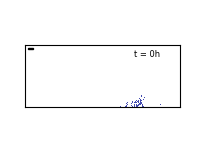

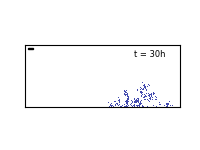

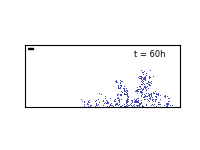

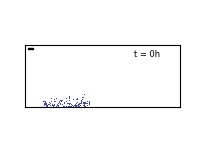

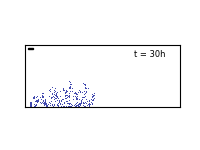

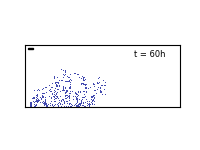

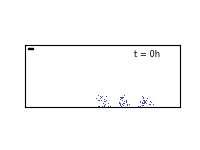

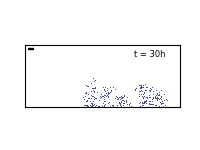

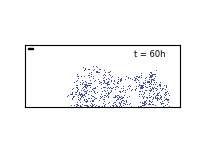

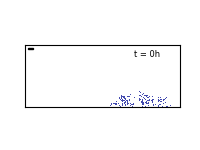

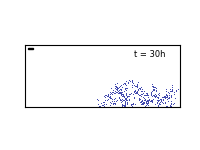

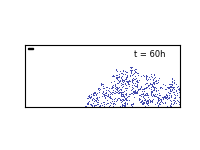

In [20]:
plates_for_plot =   ['1014_20220525', 
  # '1023_20220502',
  '1042_20220523',
# '1045_20220504',
  '1048_20220506',
  '1053_20220413',]
for plate in   plates_for_plot:
    plt.close("all")
    folders = all_folders.loc[all_folders['unique_id']==plate]
    folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
    folders = folders.sort_values(by="datetime")

    folders['time_since_begin'] = folders['datetime']-folders.iloc[0]['datetime']
    plate_num = int(plate.split('_')[0])
    shift = shifts[plate_num]
    i0 = shift
    timesteps_select = []
    folders_copy = folders.copy()
    folders_copy = folders_copy.reset_index()
    deltas = [0,30,60]
    for delta in deltas:
        target_value = folders_copy["time_since_begin"].iloc[i0] + timedelta(hours=delta)
        differences = abs(folders_copy["time_since_begin"] - target_value)
        closest_index = differences.idxmin()
        closest_row = folders_copy.loc[closest_index]
        print(differences[closest_index])
        timesteps_select.append(closest_index)
    for k,i in enumerate(timesteps_select):
        exp = Experiment(directory_targ)
        exp.load(folders.iloc[i:i+1],suffix="_width")
        for t in range(exp.ts):
            exp.load_tile_information(t)
        G = exp.nx_graph[t]
        components = nx.connected_components(G)

        # Find the largest connected component
        largest_component = max(components, key=len)

        # Create a new graph representing the largest connected component
        largest_component_graph = G.subgraph(largest_component)
        exp.nx_graph[t] = largest_component_graph
        vmax = 10
        vmin = 0
        downsizing = 10
        width = 2
        height = 1.5
        region = [[0,0],[4000*5,10000*5]]
        nodes = get_all_nodes(exp,t)

        fig,ax = plot_paper(
            exp,
            t,
            lambda edge: 5,
            region = region,
            # nodes = nodes,
            cmap=cm.get_cmap("viridis", 100),
            v_min=vmin,
            v_max=vmax,
            plot_cmap=False,
            show_background=False,
            dilation=5,
            figsize=(width, height),
            alpha = 1,
            downsizing = downsizing

        )
        rect = mpatches.Rectangle((100, 100), 1000*1.725/downsizing, 50, 
                                  color='black')

        # Add the rectangle to the plot
        ax.add_patch(rect)
        time = int((folders.iloc[i:i+1]['datetime'].iloc[0]-folders.iloc[i0]['datetime']).total_seconds() / 3600)
        # plt.savefig(os.path.join("figures",f"{folders.iloc[i:i+1]['datetime'].iloc[0]}_{plate}.pdf"), transparent=True, bbox_inches='tight')
        ax.text(3500, 400, f't = {deltas[k]}h',size = 6)

        plt.savefig(os.path.join("figures",f"{time}_{plate}.pdf"), transparent=True, bbox_inches='tight')
